In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-d7e00eb1-9a84-84d3-f220-ebebcabca98c)


In [2]:
import tensorflow as tf

In [3]:
import numpy as np

Using Tensorflow Dataset

In [4]:
import tensorflow_datasets as tfds

In [5]:
(train_data,test_data),ds_info = tfds.load(name="food101",
                                           split=["train","validation"],
                                           shuffle_files=True,
                                           as_supervised=True,
                                           with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete40X9TI/food101-train.tfrecord


  0%|          | 0/75750 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incomplete40X9TI/food101-validation.tfrecord


  0%|          | 0/25250 [00:00<?, ? examples/s]

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [6]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
class_names = ds_info.features["label"].names


Visualize

In [8]:
sample_img = train_data.take(1)

In [9]:
import matplotlib.pyplot as plt

In [10]:
def show_pic(sample_file):
  for img,lbl in sample_file:
    plt.imshow(img)
    # plt.axis(False)
    plt.title(print(class_names[lbl.numpy()]))

cheesecake


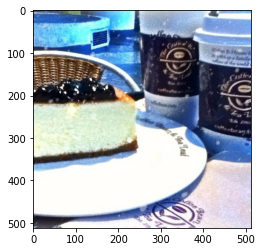

In [11]:
show_pic(sample_img)

Preprocsessing

In [12]:
def preprocess_img(image,label,img_shape=224,normalize=False):
  image = tf.image.resize(image, [img_shape, img_shape])
  image = tf.cast(image,tf.float32)
  if(normalize==True):
    image = image/255
  
  return image,label

In [13]:
for img,lbl in sample_img:
  print(img.numpy())
  img2,lbl2 = preprocess_img(img,lbl)
  print(img2.numpy())

[[[239 217 157]
  [244 222 162]
  [247 227 168]
  ...
  [119 104  73]
  [111  95  70]
  [105  89  66]]

 [[233 212 149]
  [239 218 155]
  [243 223 162]
  ...
  [117 102  71]
  [108  92  67]
  [101  85  62]]

 [[227 206 139]
  [234 213 146]
  [238 219 153]
  ...
  [117 100  70]
  [108  91  65]
  [101  83  59]]

 ...

 [[ 35   7  19]
  [ 35   7  19]
  [ 36   8  20]
  ...
  [198 181 127]
  [196 179 125]
  [193 176 122]]

 [[ 34   6  18]
  [ 34   6  18]
  [ 35   7  19]
  ...
  [200 183 129]
  [201 184 130]
  [198 181 127]]

 [[ 33   5  17]
  [ 34   6  18]
  [ 35   7  19]
  ...
  [203 186 132]
  [207 190 136]
  [206 189 135]]]
[[[238.7704    217.41327   155.4847   ]
  [242.83673   222.83673   162.55101  ]
  [240.85713   220.20918   164.2143   ]
  ...
  [131.28564   118.28565    75.7806   ]
  [123.88257   109.81113    75.09689  ]
  [106.698746   90.698746   66.4131   ]]

 [[232.16325   212.09183   141.37755  ]
  [238.86224   219.86224   151.07654  ]
  [239.94388   221.08673   155.87245  ]
  

In [14]:
train_data2 = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
train_data2 = train_data2.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data2 = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data2 = test_data2.batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_data2,test_data2

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

Callbacks

In [16]:
import os
def create_model_checkpoint(model_name, save_path="model_checkpoints"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), 
                                            verbose=0,
                                            save_best_only=True) 

In [17]:
import datetime
def create_tensorboard_callback(model_name, save_path="on_tensorboard"):
  log_dir = save_path + "/" + model_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  return tensorboard_callback

Mixed Precision Training

In [18]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [19]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [21]:
from tensorflow.keras import layers

# base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) 
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
# x = layers.Dense(128,activation="relu")(x) 
x = layers.Dense(len(class_names))(x) 
# Separate activation of output layer so we can output float32 activations as required for mixed_precision training
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model_1 = tf.keras.Model(inputs, outputs)


model_1.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step


In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_4 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-train

In [ ]:
for layer in model_1.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_3 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [ ]:
history_1 = model_1.fit(train_data2, epochs=5,steps_per_epoch=len(train_data2),
                                                     validation_data=test_data2,
                                                     callbacks=[create_tensorboard_callback("model1_feature_extraction"),
                                                                create_model_checkpoint(model_name="model1_feature_extraction")])

Epoch 1/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.8226 - accuracy: 0.5564INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


2368/2368 [==============================] - 293s 103ms/step - loss: 1.8225 - accuracy: 0.5564 - val_loss: 1.2287 - val_accuracy: 0.6756
Epoch 2/5
2368/2368 [==============================] - ETA: 0s - loss: 1.2927 - accuracy: 0.6663INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


2368/2368 [==============================] - 285s 119ms/step - loss: 1.2927 - accuracy: 0.6663 - val_loss: 1.1307 - val_accuracy: 0.6993
Epoch 3/5
2368/2368 [==============================] - ETA: 0s - loss: 1.1428 - accuracy: 0.7021INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


2368/2368 [==============================] - 255s 107ms/step - loss: 1.1428 - accuracy: 0.7021 - val_loss: 1.0842 - val_accuracy: 0.7071
Epoch 4/5
2367/2368 [============================>.] - ETA: 0s - loss: 1.0454 - accuracy: 0.7253INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


2368/2368 [==============================] - 274s 115ms/step - loss: 1.0453 - accuracy: 0.7253 - val_loss: 1.0747 - val_accuracy: 0.7085
Epoch 5/5
2367/2368 [============================>.] - ETA: 0s - loss: 0.9731 - accuracy: 0.7443INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_feature_extraction/assets


2368/2368 [==============================] - 280s 117ms/step - loss: 0.9731 - accuracy: 0.7443 - val_loss: 1.0643 - val_accuracy: 0.7107


In [ ]:
model_1_loaded = tf.keras.models.load_model("model_checkpoints/model1_feature_extraction")
model_1_loaded.evaluate(test_data2)

790/790 [==============================] - 52s 63ms/step - loss: 1.0643 - accuracy: 0.7107


[1.0642600059509277, 0.7106930613517761]

In [ ]:
def plot_loss_curves(history):
 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

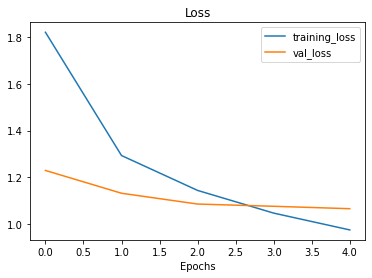

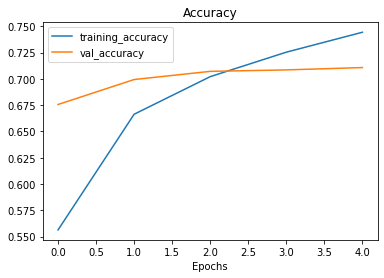

In [ ]:
plot_loss_curves(history_1)

Fine-Tuning The Model

In [ ]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-20]:
  layer.trainable = False
model_1.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable,layer.dtype, layer.dtype_policy)

0 input_4 False float32 <Policy "float32">
1 rescaling_3 False float32 <Policy "mixed_float16">
2 normalization_3 False float32 <Policy "mixed_float16">
3 stem_conv_pad False float32 <Policy "mixed_float16">
4 stem_conv False float32 <Policy "mixed_float16">
5 stem_bn False float32 <Policy "mixed_float16">
6 stem_activation False float32 <Policy "mixed_float16">
7 block1a_dwconv False float32 <Policy "mixed_float16">
8 block1a_bn False float32 <Policy "mixed_float16">
9 block1a_activation False float32 <Policy "mixed_float16">
10 block1a_se_squeeze False float32 <Policy "mixed_float16">
11 block1a_se_reshape False float32 <Policy "mixed_float16">
12 block1a_se_reduce False float32 <Policy "mixed_float16">
13 block1a_se_expand False float32 <Policy "mixed_float16">
14 block1a_se_excite False float32 <Policy "mixed_float16">
15 block1a_project_conv False float32 <Policy "mixed_float16">
16 block1a_project_bn False float32 <Policy "mixed_float16">
17 block2a_expand_conv False float32 <Pol

In [ ]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer (GlobalAverag  (None, 1280)             0         
 ePooling2D)                                                     
                                                                 
 dense_4 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 1,480,341
Non-tra

In [25]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", 
                                                  patience=3)

In [26]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2,
                                                 patience=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [ ]:
history_2 = model_1.fit(train_data2,
                        epochs=100,
                        validation_data=test_data2,
                        initial_epoch=history_1.epoch[-1], # start from previous last epoch
                        callbacks=[create_tensorboard_callback("model1_fine"),create_model_checkpoint(model_name="model1_fine"),early_stopping,reduce_lr])

Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8258 - accuracy: 0.7780INFO:tensorflow:Assets written to: model_checkpoints/model1_fine/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_fine/assets


2368/2368 [==============================] - 301s 123ms/step - loss: 0.8258 - accuracy: 0.7780 - val_loss: 0.9827 - val_accuracy: 0.7336 - lr: 1.0000e-04
Epoch 6/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.6248 - accuracy: 0.8324INFO:tensorflow:Assets written to: model_checkpoints/model1_fine/assets


INFO:tensorflow:Assets written to: model_checkpoints/model1_fine/assets


2368/2368 [==============================] - 255s 107ms/step - loss: 0.6248 - accuracy: 0.8324 - val_loss: 0.9826 - val_accuracy: 0.7399 - lr: 1.0000e-04
Epoch 7/100
2368/2368 [==============================] - ETA: 0s - loss: 0.4757 - accuracy: 0.8730
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 256s 107ms/step - loss: 0.4757 - accuracy: 0.8730 - val_loss: 1.0367 - val_accuracy: 0.7363 - lr: 1.0000e-04
Epoch 8/100
2368/2368 [==============================] - 221s 92ms/step - loss: 0.2827 - accuracy: 0.9323 - val_loss: 1.0604 - val_accuracy: 0.7425 - lr: 2.0000e-05
Epoch 9/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.2442 - accuracy: 0.9438
Epoch 9: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
2368/2368 [==============================] - 257s 107ms/step - loss: 0.2442 - accuracy: 0.9438 - val_loss: 1.0942 - val_accuracy: 0.7402 - lr: 2.0000e-05


In [ ]:
model_1_loaded_fine = tf.keras.models.load_model("model_checkpoints/model1_fine")
model_1_loaded_fine.evaluate(test_data2)

790/790 [==============================] - 55s 67ms/step - loss: 0.9826 - accuracy: 0.7399


[0.9825883507728577, 0.7398812174797058]

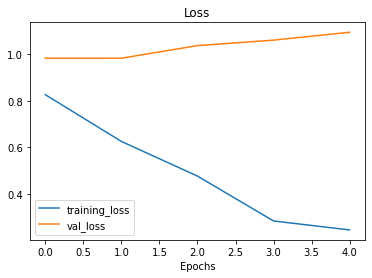

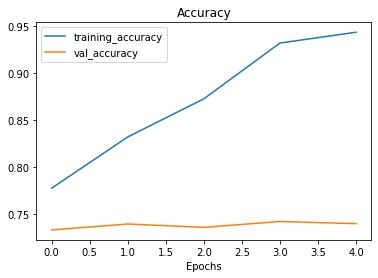

In [ ]:
plot_loss_curves(history_2)


In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):

    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]


    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]


    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') 
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

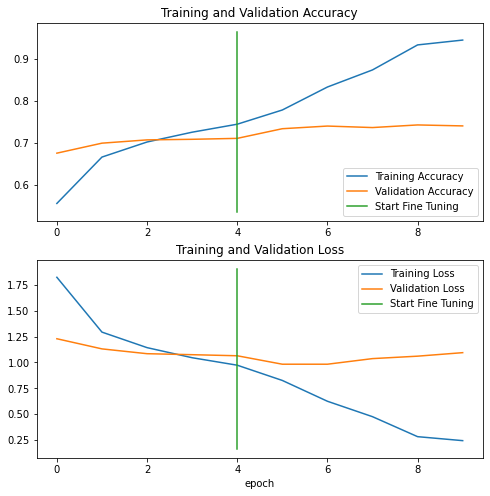

In [ ]:
compare_historys(history_1,history_2)

Let's add a LSTM Layer

In [ ]:
inputs_new = layers.Input(shape=input_shape, name="input_layer_new")
y = base_model(inputs_new, training=False) 
y = layers.GlobalAveragePooling2D(name="pooling_layer2")(y)
# x = layers.Dense(128,activation="relu")(x) 
# print(y.shape)
y = layers.Bidirectional(layers.LSTM(224))(tf.expand_dims(y,axis=1))
# z = tf.expand_dims(y,axis=0)
# print(z.shape)
# print(y.shape)
y = layers.Dense(len(class_names))(y) 
# Separate activation of output layer so we can output float32 activations as required for mixed_precision training
outputs_new = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(y) 
model_2 = tf.keras.Model(inputs_new, outputs_new)


model_2.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer_new (InputLayer  [(None, 224, 224, 3)]    0         
 )                                                               
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 pooling_layer2 (GlobalAvera  (None, 1280)             0         
 gePooling2D)                                                    
                                                                 
 tf.expand_dims_6 (TFOpLambd  (None, 1, 1280)          0         
 a)                                                              
                                                                 
 bidirectional_5 (Bidirectio  (None, 448)              2696960   
 nal)                                                     

In [ ]:
history_3 = model_2.fit(train_data2,
                        epochs=100,
                        validation_data=test_data2,
                        callbacks=[create_tensorboard_callback("model2_lstm"),create_model_checkpoint(model_name="model2_lstm"),early_stopping,reduce_lr])

Epoch 1/100
2368/2368 [==============================] - ETA: 0s - loss: 1.6107 - accuracy: 0.5831

INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


2368/2368 [==============================] - 340s 138ms/step - loss: 1.6107 - accuracy: 0.5831 - val_loss: 1.0867 - val_accuracy: 0.7049 - lr: 0.0010
Epoch 2/100
2367/2368 [============================>.] - ETA: 0s - loss: 1.0591 - accuracy: 0.7147

INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


2368/2368 [==============================] - 308s 129ms/step - loss: 1.0591 - accuracy: 0.7147 - val_loss: 1.0222 - val_accuracy: 0.7248 - lr: 0.0010
Epoch 3/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.8109 - accuracy: 0.7755

INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


2368/2368 [==============================] - 274s 115ms/step - loss: 0.8109 - accuracy: 0.7755 - val_loss: 0.9956 - val_accuracy: 0.7349 - lr: 0.0010
Epoch 4/100
2368/2368 [==============================] - 261s 109ms/step - loss: 0.6297 - accuracy: 0.8197 - val_loss: 1.0430 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 5/100
2367/2368 [============================>.] - ETA: 0s - loss: 0.4970 - accuracy: 0.8544
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 226s 94ms/step - loss: 0.4970 - accuracy: 0.8544 - val_loss: 1.0731 - val_accuracy: 0.7311 - lr: 0.0010
Epoch 6/100
2368/2368 [==============================] - ETA: 0s - loss: 0.1859 - accuracy: 0.9478

INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


INFO:tensorflow:Assets written to: model_checkpoints/model2_lstm/assets


2368/2368 [==============================] - 275s 115ms/step - loss: 0.1859 - accuracy: 0.9478 - val_loss: 0.9434 - val_accuracy: 0.7728 - lr: 2.0000e-04
Epoch 7/100
2368/2368 [==============================] - 226s 94ms/step - loss: 0.0750 - accuracy: 0.9838 - val_loss: 0.9901 - val_accuracy: 0.7746 - lr: 2.0000e-04
Epoch 8/100
2368/2368 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9959
Epoch 8: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
2368/2368 [==============================] - 226s 94ms/step - loss: 0.0314 - accuracy: 0.9959 - val_loss: 1.0596 - val_accuracy: 0.7728 - lr: 2.0000e-04
Epoch 9/100
2368/2368 [==============================] - 261s 109ms/step - loss: 0.0118 - accuracy: 0.9992 - val_loss: 1.0717 - val_accuracy: 0.7763 - lr: 4.0000e-05


In [ ]:
model_2_loaded = tf.keras.models.load_model("model_checkpoints/model2_lstm")
model_2_loaded.evaluate(test_data2)

790/790 [==============================] - 62s 74ms/step - loss: 0.9434 - accuracy: 0.7728


[0.9434129595756531, 0.7727524638175964]

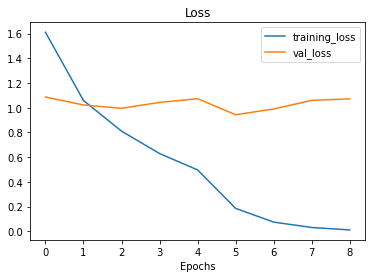

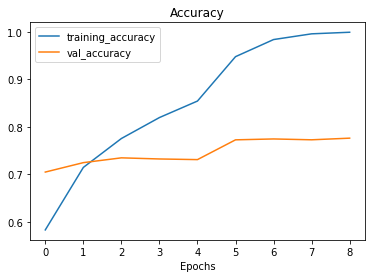

In [ ]:
plot_loss_curves(history_3)

In [ ]:
# sample_1 = train_data.take(1)
def get_and_pred(sample_file):
  for img,lbl in sample_file:
    img,lbl = preprocess_img(img,lbl)
    preds_prob = model_2.predict(tf.expand_dims(img,axis=0))
    preds = preds_prob.argmax()
    this_title = "Image: "+class_names[lbl.numpy()]+" : "+"Predicted: "+class_names[preds]+" , Probability: "+ str(np.max(preds_prob))
    clr = "r"
    if(class_names[lbl.numpy()]==class_names[preds]):
      clr = "g"

    plt.title(this_title,color=clr)
    plt.axis(False)
    img = img/255
    plt.imshow(img)



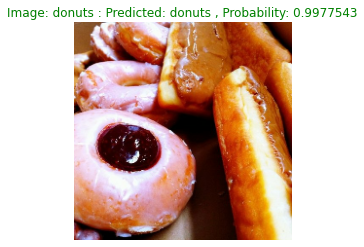

In [ ]:
get_and_pred(sample_img)

A simple model from scratch

In [22]:
model = tf.keras.models.Sequential([ 
      layers.Conv2D(filters = 64 , kernel_size = (3,3), activation="relu", input_shape=(224,224,3)),
      layers.MaxPooling2D(pool_size = (3,3)),
      layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      layers.MaxPooling2D(pool_size = (3,3)),
      layers.Conv2D(filters = 32 , kernel_size = (3,3), activation="relu"),
      layers.MaxPooling2D(pool_size = (3,3)),
      layers.Flatten(),
      layers.Dense(units = 512 , activation="relu"),
      layers.Dropout(rate = 0.5),
      layers.Dense(units = len(class_names) , activation="softmax")
  ])

In [23]:
model.compile(optimizer = tf.optimizers.Adam(learning_rate = 0.001),
                loss = "sparse_categorical_crossentropy",
                metrics=['accuracy'])

In [28]:
history_4 =  model.fit(train_data2,
                        epochs=10,
                        validation_data=test_data2,
                        callbacks=[create_tensorboard_callback("model_simple"),create_model_checkpoint(model_name="model_simple"),early_stopping,reduce_lr])

Epoch 1/10
2367/2368 [============================>.] - ETA: 0s - loss: 3.9590 - accuracy: 0.1055INFO:tensorflow:Assets written to: model_checkpoints/model_simple/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_simple/assets


2368/2368 [==============================] - 197s 81ms/step - loss: 3.9590 - accuracy: 0.1055 - val_loss: 3.9929 - val_accuracy: 0.1035 - lr: 0.0010
Epoch 2/10
2367/2368 [============================>.] - ETA: 0s - loss: 3.8710 - accuracy: 0.1184INFO:tensorflow:Assets written to: model_checkpoints/model_simple/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_simple/assets


2368/2368 [==============================] - 187s 78ms/step - loss: 3.8711 - accuracy: 0.1184 - val_loss: 3.9583 - val_accuracy: 0.1081 - lr: 0.0010
Epoch 3/10
2367/2368 [============================>.] - ETA: 0s - loss: 3.7994 - accuracy: 0.1293INFO:tensorflow:Assets written to: model_checkpoints/model_simple/assets


INFO:tensorflow:Assets written to: model_checkpoints/model_simple/assets


2368/2368 [==============================] - 191s 80ms/step - loss: 3.7994 - accuracy: 0.1293 - val_loss: 3.9227 - val_accuracy: 0.1090 - lr: 0.0010
Epoch 4/10
2368/2368 [==============================] - 187s 78ms/step - loss: 3.7139 - accuracy: 0.1451 - val_loss: 3.9739 - val_accuracy: 0.1063 - lr: 0.0010
Epoch 5/10
2367/2368 [============================>.] - ETA: 0s - loss: 3.6483 - accuracy: 0.1543
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
2368/2368 [==============================] - 186s 78ms/step - loss: 3.6483 - accuracy: 0.1543 - val_loss: 4.0441 - val_accuracy: 0.1021 - lr: 0.0010
Epoch 6/10
2368/2368 [==============================] - 188s 79ms/step - loss: 3.3392 - accuracy: 0.2082 - val_loss: 3.9710 - val_accuracy: 0.1164 - lr: 2.0000e-04
